## **Preparation of networks**

Here, we consider that all the networks of interest were already generated and saved. This way, we will augment the networks with extra information
and perform extra calculations to generate data ready for plotting.

Let us consider the two types of networks:<br>
1. **Cities flux networks**<br>
2. **Cities to Hospitals flux networks**<br>

### **1. Between cities flux networks**

### **2. Cities to Hospitals flux networks**

## **Lib**

In [251]:
# -- Bib
import os
import sys
sys.path.append("..")

import networkx as nx
import geopandas as gpd
import pandas as pd
import glob
import pickle
from shapely.geometry import Point
import geopy
from geopy.distance import distance, geodesic
import matplotlib.pyplot as plt
from collections import defaultdict

from fluxsus.preprocessing.processnet import NetProperties

In [3]:
idx = pd.IndexSlice

## **Load base data**

In [4]:
# -- base paths
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
#basepath = os.path.join(os.environ["HOME"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
geopath = os.path.join(basepath, "shapefilesceqgis")
gmlpath = os.path.join(basepath, "redes_aih")

In [5]:
# -- load geo
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
geodata_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GEOCOD7            184 non-null    object  
 1   NM_MUNICIP         184 non-null    object  
 2   GEOCOD6            184 non-null    object  
 3   MACRO_ID           184 non-null    int64   
 4   CRES_ID            184 non-null    int64   
 5   geometry_municip   184 non-null    geometry
 6   MACRO_NOME         184 non-null    object  
 7   geometry_macro     184 non-null    geometry
 8   geometry_cres      184 non-null    geometry
 9   MACRO_ID_PROPOSAL  184 non-null    int64   
 10  centroid_municip   184 non-null    geometry
 11  municip_lon        184 non-null    float64 
 12  municip_lat        184 non-null    float64 
 13  2010               184 non-null    float64 
 14  2011               184 non-null    float64 
 15  2012               184 non-null    float64 
 16  

## **0. Health equipaments**

In [65]:
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df.merge(geodata_df[["GEOCOD6", "MACRO_ID"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left")

leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet"))

graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

In [66]:
valid_cnes = []
for v in graph.nodes():
    if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0:
        valid_cnes.append(graph.nodes[v]['code'])

valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

In [67]:
# -- geolocation of hospitals
cols = ["CNES", "CODUFMUN", "MACRO_ID", "latitude", "longitude", "COMPETEN_MAX", "COMPETEN_MIN"]
valid_cnes_df[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))

In [69]:
def get_leitos_municipio(municip_code, leitos_df, cnes_df, valid_cnes):
    cnes_of_municipio = cnes_df[(cnes_df["CODUFMUN"]==municip_code) & (cnes_df["CNES"].isin(valid_cnes))]["CNES"].tolist()
    if len(cnes_of_municipio)==0:
        return 0
    else:
        n_leitos_municipio = max(leitos_df.loc[:, idx[cnes_of_municipio, "NUMLEITOS_PRINC"]].sum(axis=1).tolist()[-5:])
        return n_leitos_municipio


muni_leitos = {}
for muni in geodata_df["GEOCOD6"].tolist():
    n_leitos_municipio = get_leitos_municipio(muni, leitos_df, cnes_df, valid_cnes)
    muni_leitos[muni] = n_leitos_municipio

geodata_df["NUMLEITOS"] = geodata_df["GEOCOD6"].map(muni_leitos)
geodata_df[["GEOCOD6", "NUMLEITOS"]].to_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_por_municipio_1801_2306.parquet"))
geodata_df.head(3)

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,MACRO_ID_PROPOSAL,...,2015,2016,2017,2018,2019,2020,2021,2022,MACRO_COLOR,NUMLEITOS
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",3,...,11259.0,11380.0,11498.0,11619.0,11737.0,11853.0,11965.0,10038.0,#073b4c,0.0
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",1,...,14486.0,14598.0,14707.0,14820.0,14929.0,15036.0,15140.0,14027.0,#ef476f,0.0
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",2,...,60722.0,61208.0,61679.0,62165.0,62641.0,63104.0,63556.0,64806.0,#118ab2,38.0


In [62]:
get_leitos_municipio("231330", cnes_df, valid_cnes)

108

In [60]:
cnes_df[cnes_df["CNES"]=="2328046"][["QTLEITP1", "QTLEITP2", "QTLEITP3"]]

,QTLEITP1,QTLEITP2,QTLEITP3
15038,23,70,15


### **0.4 CCA for health**

In [220]:
# -- create the two datasets
# -- one: geolocation of health units who genereated an AIH during 2018-2023 (this period can be flexible)
# -- two: geolocation of census units with the number of population contained in each unit
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df[["CNES", "latitude", "longitude"]]

pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "geometry", "Pop_setor_censo2010"]].copy()
pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
pop_census_df1 = pop_census_df1.drop('geometry', axis=1).rename({'centroid': 'geometry'}, axis=1).set_geometry('geometry')

# -- the city-hospital bipartite network can provide which health units are actually relevant for analysis (generated at least one AIH during the period chosen)
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

# -- filter only the relevant health units
valid_cnes = [ graph.nodes[v]['code'] for v in graph.nodes() if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0 ]
valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

# -- define the geometry of the health units
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry', crs="EPSG:4674")
# -- health units in projection for meters
valid_cnes_df1 = valid_cnes_df.to_crs(epsg=29194).copy()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_18672\215858703.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_18672\215858703.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)


In [221]:
# -- set kilometers buffer
set_km = 10
valid_cnes_df1["circle_geometry"] = valid_cnes_df1["geometry"].apply(lambda x: x.buffer(set_km*1000))
valid_cnes_df1 = valid_cnes_df1.drop('geometry', axis=1).rename({'circle_geometry': 'geometry'}, axis=1)
valid_cnes_df1 = valid_cnes_df1.to_crs(epsg=4674)

In [230]:
pop_census_df1.shape

(13615, 3)

In [224]:
cond = valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].contains(pop_census_df1)
pop_census_df1[cond]

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_18672\646286889.py:1: UserWarning: The indices of the two GeoSeries are different.
  cond = valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].contains(pop_census_df1)
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\geopandas\geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,CD_GEOCODI,Pop_setor_censo2010,geometry


**Create CCA function**

In [249]:
setor_to_hospital = dict(zip(pop_census_df1["CD_GEOCODI"], [-1 for n in range(pop_census_df1.shape[0]) ]))

# -- verify which point belongs to which hospital
for index in range(valid_cnes_df1.shape[0]):
    current_cnes = valid_cnes_df1['CNES'].iloc[index]
    current_polygon = valid_cnes_df1.geometry.iloc[index]

    # -- verification
    cod_setores = pop_census_df1[pop_census_df1.geometry.within(current_polygon)]["CD_GEOCODI"].tolist()
    if len(cod_setores)>0:
        [ setor_to_hospital.update({ current_setor_cod : current_cnes }) for current_setor_cod in cod_setores ]

hospital_to_hospital = defaultdict()


In [250]:
setor_to_hospital

{'230030925000003': -1,
 '230030925000004': -1,
 '230030925000005': -1,
 '230030925000006': -1,
 '230030925000007': -1,
 '230030925000008': -1,
 '230030925000009': -1,
 '230030925000010': -1,
 '230030925000011': -1,
 '230030925000012': -1,
 '230030930000001': -1,
 '230030930000002': -1,
 '230030930000003': -1,
 '230030930000004': -1,
 '230075428000005': -1,
 '230075430000001': -1,
 '230075430000002': -1,
 '230075430000003': -1,
 '230075430000004': -1,
 '230075435000001': -1,
 '230075435000002': -1,
 '230075440000001': -1,
 '230075440000002': -1,
 '230075440000003': -1,
 '230075440000004': -1,
 '230075440000005': -1,
 '230075440000006': -1,
 '230075440000007': -1,
 '230080405000001': '2563347',
 '230080405000002': '2563347',
 '230100015000012': '2564769',
 '230100015000013': '2564769',
 '230100015000014': '2564769',
 '230100015000015': '2564769',
 '230100015000016': '2564769',
 '230100015000017': '2564769',
 '230100015000018': '2564769',
 '230100015000019': '2564769',
 '230100015000020'

<Axes: >

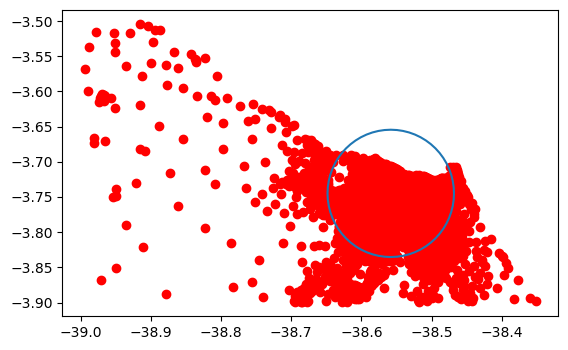

In [244]:
fig, ax = plt.subplots(1)

valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].boundary.plot(ax=ax)
ex = pop_census_df1.cx[-39:-38, -3.5:-3.9]
ex.plot(ax=ax, color='red')

In [229]:
valid_cnes_df1['geometry'].contains(pop_census_df1['geometry']).sum()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_18672\707215116.py:1: UserWarning: The indices of the two GeoSeries are different.
  valid_cnes_df1['geometry'].contains(pop_census_df1['geometry']).sum()


3

In [247]:
pol = valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].geometry.iloc[0]
pop_census_df1.geometry.within(pol).sum()

2704

<Axes: >

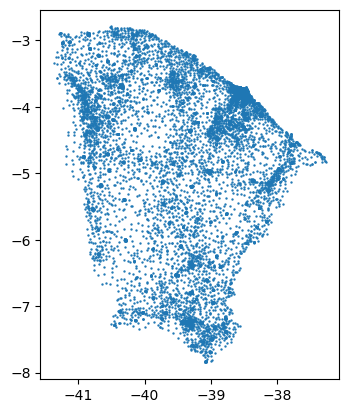

In [217]:
pop_census_df1.plot(markersize=0.5)

In [245]:
valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].contains(ex)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_18672\3101333645.py:1: UserWarning: The indices of the two GeoSeries are different.
  valid_cnes_df1[valid_cnes_df1["CNES"]=="2561417"].contains(ex)


517      False
518      False
519      False
520      False
521      False
         ...  
12380    False
12381    False
12382    False
12383    False
13733    False
Length: 3865, dtype: bool

<Axes: >

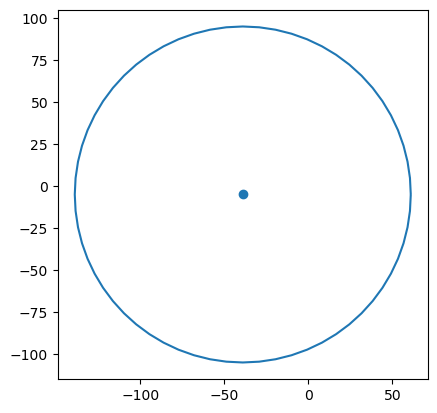

In [165]:
gpd.GeoSeries([x, p]).plot()

In [166]:
p.distance(x)

99.87954562051722

## **0. Time series of hospitals and hospital beds per macro**

In [7]:
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet")).fillna(0)

# -- get info on macro for each CNES
cnes_macro = cnes_df.merge(geodata_df[["MACRO_ID", "MACRO_ID_PROPOSAL", "GEOCOD6"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left")[["CNES", "CODUFMUN", "MACRO_ID", "MACRO_ID_PROPOSAL"]]

In [8]:
# -- objective: for each macro, sum the number of hospital beds of the hospitals inside the macro
def count_hospitalbed_per_macro(leitos_df, macro_id, cnes_macro, macro_col="MACRO_ID"):
    ''' 
        Return the number of hospital beds (main and all) for the macrorregion for each time
        point.
    '''
    cnes_list = cnes_macro[cnes_macro[macro_col]==macro_id]["CNES"].tolist()
    subset_pri =  leitos_df.loc[:, idx[cnes_list, 'NUMLEITOS_PRINC']].sum(axis=1)
    subset_todos =  leitos_df.loc[:, idx[cnes_list, 'NUMLEITOS_TODOS']].sum(axis=1)
    macro_res = pd.DataFrame({
        "period": leitos_df.index, "macro_leitos_princ": subset_pri, "macro_leitos_todos": subset_todos
    })
    return macro_res

macro_original = { n : count_hospitalbed_per_macro(leitos_df, n, cnes_macro, macro_col="MACRO_ID") for n in range(1,5+1)  }
macro_proposal = { n : count_hospitalbed_per_macro(leitos_df, n, cnes_macro, macro_col="MACRO_ID_PROPOSAL") for n in range(1,8+1)  }

In [9]:
macro_original = pd.concat([ macro_original[key] for key in macro_original.keys() ], axis=1, keys=macro_original.keys())
macro_proposal = pd.concat([ macro_proposal[key] for key in macro_proposal.keys() ], axis=1, keys=macro_proposal.keys())


In [54]:
macro_original.to_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_original_beds.parquet"))
macro_proposal.to_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_proposal_beds.parquet"))


In [55]:
macro_original.head()

1                                            2                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801             6406.0             9918.0   0801              499.0   
0802   0802             6450.0             9962.0   0802              499.0   
0803   0803             6450.0             9971.0   0803              499.0   
0804   0804             6611.0            10148.0   0804              499.0   
0805   0805             6632.0            10192.0   0805              499.0   

                             3                                            4  \
     macro_leitos_todos period macro_leitos_princ macro_leitos_todos period   
0801              882.0   0801              546.0              901.0   0801   
0802              882.0   0802              546.0              901.0   0802   
0803              884.0   0803              546.0              908.0   0803   
0804              884.0   0804              552.0              914.0   0804   
0805              884.0   0805              552.0              914.0   0805   

                                                5                     \
     macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801             1389.0             2414.0   0801             2180.0   
0802             1389.0             2412.0   0802             2186.0   
0803             1389.0             2418.0   0803             2192.0   
0804             1362.0             2388.0   0804             2189.0   
0805             1365.0             2391.0   0805             2184.0   

                         
     macro_leitos_todos  
0801             3362.0  
0802             3368.0  
0803             3383.0  
0804             3371.0  
0805             3367.0

In [56]:
macro_proposal.head()

1                                            2                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801             6111.0             9337.0   0801              520.0   
0802   0802             6155.0             9381.0   0802              520.0   
0803   0803             6155.0             9390.0   0803              520.0   
0804   0804             6315.0             9565.0   0804              497.0   
0805   0805             6352.0             9633.0   0805              480.0   

                             3                                            4  \
     macro_leitos_todos period macro_leitos_princ macro_leitos_todos period   
0801             1031.0   0801             1606.0             2325.0   0801   
0802             1031.0   0802             1607.0             2326.0   0802   
0803             1037.0   0803             1613.0             2337.0   0803   
0804             1005.0   0804             1613.0             2330.0   0804   
0805              980.0   0805             1613.0             2330.0   0805   

      ...                  5      6                                        \
      ... macro_leitos_todos period macro_leitos_princ macro_leitos_todos   
0801  ...              721.0   0801              558.0              929.0   
0802  ...              721.0   0802              558.0              929.0   
0803  ...              723.0   0803              558.0              936.0   
0804  ...              723.0   0804              564.0              942.0   
0805  ...              723.0   0805              564.0              942.0   

          7                                            8                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801              386.0              623.0   0801              855.0   
0802   0802              386.0              622.0   0802              855.0   
0803   0803              386.0              622.0   0803              855.0   
0804   0804              386.0              629.0   0804              852.0   
0805   0805              390.0              633.0   0805              852.0   

                         
     macro_leitos_todos  
0801             1474.0  
0802             1473.0  
0803             1473.0  
0804             1470.0  
0805             1470.0  

[5 rows x 24 columns]

## **1. Between cities flux networks**

### **1.1 Mapping and macros**

In [76]:
netsuffix = "agg_2001_2012"

# -- load and perform calculations
fname = f"cityfluxnet_{netsuffix}.gml"
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", fname))
netprop = NetProperties(graph).calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
netprop.process_infomap_graph().process_louvain_graph()
graph = netprop.graph

# -- complementary info on graph (macro proposal)
#temp_ = dict(zip(geodata_df["GEOCOD6"], geodata_df["MACRO_ID_PROPOSAL"]))
#for v in graph.nodes():
#    graph.nodes[v]['macro_id_proposal'] = temp_[graph.nodes[v]['municipio_code']]

# -- add modules info on the geodataframe
geodata_df1 = geodata_df.copy()
geodata_df1["infomap_count_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_count_module_id'] for u in graph.nodes()})
geodata_df1["infomap_cost_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_cost_module_id'] for u in graph.nodes()})
geodata_df1["louvain_count_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_count_module_id'] for u in graph.nodes()})
geodata_df1["louvain_cost_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_cost_module_id'] for u in graph.nodes()})
geodata_df1["inflow_people"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_people'] for u in graph.nodes()})
geodata_df1["inflow_cost"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_cost'] for u in graph.nodes()})

found 9 modules with codelength: 2.5192578014211713
found 3 modules with codelength: 2.4760044338086376


In [78]:
# -- specify base colors
# ---- original colors based on specific cities
# ---- new modules will be colored with the original colors if one of the cities below is included

cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}

citycode_colors = {"230440": "#ef476f", "230730": "#073b4c", "230410": "#118ab2", "231140": "#ffb300", "231180": "#04ae81"}
citylabel_colors = {"58": "#ef476f", "98": "#073b4c", "49": "#118ab2", "150": "#ffb300", "154": "#04ae81"}
extra_colors = ["#00756a", "#bcb20f", "#ff8239", "#c6881c", "#00a2a3", "#4d4d4d", "#f0e2e7", "#dbfe87", "#1c448e"]

# -- create new cmap for new modules
#cmap_infomap_count, cmap_infomap_cost = {}, {}
#cmap_louvain_count, cmap_louvain_cost = {}, {}

def get_cmap(graph, citycode_colors, extra_colors, property_name):
    cmap = {}
    n_modules = len(set( [ graph.nodes[v][property_name] for v in graph.nodes() ] ))
    for v in graph.nodes():
        if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
            if graph.nodes[v][property_name] not in cmap.keys():
                cmap.update({graph.nodes[v][property_name] : citycode_colors[graph.nodes[v]['municipio_code']]})
    extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap.values() ]
    dummy_index = 0
    for n in range(n_modules):
        if n+1 not in cmap.keys():
            cmap.update({ n+1: extra_colors_[dummy_index]})
            dummy_index+=1
    return cmap

cmap_11 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_count_module_id')
cmap_13 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_cost_module_id')
cmap_21 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_count_module_id')
cmap_23 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_cost_module_id')
#cmap_prop = get_cmap(graph, citycode_colors, extra_colors, 'macro_id_proposal')


geodata_df1["INFOMAP_COUNT_COLOR"] = geodata_df1["infomap_count_module"].map(cmap_11)
geodata_df1["INFOMAP_COST_COLOR"] = geodata_df1["infomap_cost_module"].map(cmap_13)
geodata_df1["LOUVAIN_COUNT_COLOR"] = geodata_df1["louvain_count_module"].map(cmap_21)
geodata_df1["LOUVAIN_COST_COLOR"] = geodata_df1["louvain_cost_module"].map(cmap_23)
#geodata_df1["MACRO_PROPOSAL_COLOR"] = geodata_df1["MACRO_ID_PROPOSAL"].map(cmap_prop)

In [79]:
cmap_11

{7: '#118ab2',
 1: '#ef476f',
 2: '#073b4c',
 9: '#04ae81',
 3: '#00756a',
 4: '#bcb20f',
 5: '#ff8239',
 6: '#c6881c',
 8: '#00a2a3'}

In [80]:
geodata_df1 = geodata_df1.drop(["centroid_municip"], axis=1)
geodata_df1.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geoforplot_{netsuffix}.parquet"))

In [54]:
geodata_df1.columns

Index(['GEOCOD7', 'NM_MUNICIP', 'GEOCOD6', 'MACRO_ID', 'CRES_ID',
       'geometry_municip', 'MACRO_NOME', 'geometry_macro', 'geometry_cres',
       'MACRO_ID_PROPOSAL', 'municip_lon', 'municip_lat', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', 'MACRO_COLOR', 'infomap_count_module',
       'infomap_cost_module', 'louvain_count_module', 'louvain_cost_module',
       'inflow_people', 'inflow_cost', 'INFOMAP_COUNT_COLOR',
       'INFOMAP_COST_COLOR', 'LOUVAIN_COUNT_COLOR', 'LOUVAIN_COST_COLOR'],
      dtype='object')

### **1.1 time series networks - Fluxes over time**

In [85]:
fnames = sorted(glob.glob(os.path.join(gmlpath, "novo_completo", "*noverlap*")))
list_of_networks = [ nx.read_gml(fname) for fname in fnames ]

**Define utility functions**

Calculate the incoming, outcoming and internal flows for each macrorregion.

In [86]:
def get_fluxes_macro(graph, macro_indices=["1", "2", "3", "4", "5"]):
    '''
        Calculate the incoming and outgoing fluxes for each macro. Also calculate the internal flux. 
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": 0,
            "OUTGOING": 0,
            "INTERNAL": 0
        } for ind in macro_indices
    }

    # -- calculation
    for src, tgt in graph.edges():
        cur_action = graph.edges[(src, tgt)]
        
        src_macro, tgt_macro = str(int(cur_action['source_macro'])), str(int(cur_action['target_macro']))
        flux_count = cur_action['admission_count']

        if src_macro==tgt_macro:
            macro_in_out[src_macro]["INTERNAL"] += flux_count
        else:
            macro_in_out[src_macro]["OUTGOING"] += flux_count
            macro_in_out[tgt_macro]["INCOMING"] += flux_count
    return macro_in_out

def macro_flows_time(list_of_graphs, macro_indices=["1", "2", "3", "4", "5"]):
    ''' 
    
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": [],
            "OUTGOING": [],
            "INTERNAL": []
        } for ind in macro_indices
    }
    for graph in list_of_graphs:
        res = get_fluxes_macro(graph)
        for key in res.keys():
            macro_in_out[key]["INCOMING"].append(res[key]["INCOMING"])
            macro_in_out[key]["OUTGOING"].append(res[key]["OUTGOING"])
            macro_in_out[key]["INTERNAL"].append(res[key]["INTERNAL"])
    return macro_in_out

In [90]:
macro_flows = macro_flows_time(list_of_networks)
with open(os.path.join(gmlpath, 'dados_for_plot', 'macro_original_fluxes.pickle'), 'wb') as handle:
    pickle.dump(macro_flows, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
import graph_tool as gt
from graph_tool.inference import minimize_blockmodel_dl

In [40]:
fname = "cityfluxnet_agg_1801_2212.gml"
graph = gt.load_graph(os.path.join(gmlpath, "novo_completo", fname))

In [24]:
state = minimize_blockmodel_dl(graph)
modules_v = state.get_blocks()

In [30]:
# YYMM
fname = "cityfluxnet_agg_1801_2212.gml"
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", fname))

In [34]:
for v in graph.nodes():
    break
graph.nodes[v]

{'municipio_code': '230010',
 'municipio_name': 'ABAIARA',
 'macro_id': 5,
 'macro_new_id': 3,
 'macro_name': 'Superintendência Regional de Saúde Cariri',
 'cres_id': 19,
 'lat': -7.35990681440754,
 'lon': -39.03753839591732}

In [33]:
for u, v in graph.edges():
    break
graph.edges[(u,v)]

{'admission_count': 27,
 'total_cost': 16354.65,
 'source_macro': 5.0,
 'target_macro': 5,
 'source_micro': 19.0,
 'target_micro': 19,
 'same_macro': 5.0,
 'same_micro': 19.0,
 'admission_count_ch1': 0.0,
 'total_cost_ch1': 0.0,
 'admission_count_ch2': 0.0,
 'total_cost_ch2': 0.0,
 'admission_count_ch3': 0.0,
 'total_cost_ch3': 0.0,
 'admission_count_ch4': 0.0,
 'total_cost_ch4': 0.0,
 'admission_count_ch5': 0.0,
 'total_cost_ch5': 0.0,
 'admission_count_ch6': 0.0,
 'total_cost_ch6': 0.0,
 'admission_count_ch7': 0.0,
 'total_cost_ch7': 0.0,
 'admission_count_ch8': 0.0,
 'total_cost_ch8': 0.0,
 'admission_count_ch9': 0.0,
 'total_cost_ch9': 0.0,
 'admission_count_ch10': 0.0,
 'total_cost_ch10': 0.0,
 'admission_count_ch11': 6.0,
 'total_cost_ch11': 3420.04,
 'admission_count_ch12': 0.0,
 'total_cost_ch12': 0.0,
 'admission_count_ch13': 1.0,
 'total_cost_ch13': 948.13,
 'admission_count_ch14': 6.0,
 'total_cost_ch14': 2934.94,
 'admission_count_ch15': 14.0,
 'total_cost_ch15': 9051.54,
 

## **2. Cities to Hospitals flux networks**